# EE 559 Project
Ronald Huang & Henry Chen

### Import Libraries

In [1]:
# Import packages
import math
import numpy as np
import pandas as pd
import seaborn as sns


# For Computing Priors
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import normalize



# For Model Selection
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge




import matplotlib.pyplot as plt


# For plotting ROC and Precision Recall curves
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay


# For OS agnostic path handling
from os import path


### Data Import

In [61]:
#Read in data
data_path = 'data/FLIR_groups1and2_train.csv'

read_data = pd.read_csv(data_path, skiprows = 2)
training_data_set = read_data.iloc[:, 2:]

#Seperate by Rounds
round_1 = training_data_set.iloc[:, :27]
round_2 = training_data_set.iloc[:, 28:55]
round_3 = training_data_set.iloc[:, 56:83]
round_4 = training_data_set.iloc[:, 84:111]

In [62]:
#seperate extra features
extra_features = training_data_set[['Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Distance']]
target = training_data_set['aveOralM']


In [63]:
# One-Hot-Encoding
extra_features_copy = extra_features.copy()
# extra_features = pd.get_dummies(extra_features, columns=['Gender', 'Age', 'Ethnicity'])
extra_features = pd.get_dummies(extra_features_copy, columns=['Gender', 'Age', 'Ethnicity'])

extra_features_copy = extra_features
extra_features_copy

,T_atm,Humidity,Distance,Gender_Female,Gender_Male,Age_18-20,Age_21-25,Age_21-30,Age_26-30,Age_31-40,Age_41-50,Age_51-60,Age_>60,Ethnicity_American Indian or Alaskan Native,Ethnicity_Asian,Ethnicity_Black or African-American,Ethnicity_Hispanic/Latino,Ethnicity_Multiracial,Ethnicity_White
0,24.0,28.0,0.80,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True
1,24.0,26.0,0.80,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
2,24.0,26.0,0.80,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,24.0,27.0,0.80,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
4,24.0,27.0,0.80,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,24.4,13.5,0.60,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
706,24.4,14.7,0.63,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
707,22.0,30.0,0.60,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False
708,22.0,30.0,0.60,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True


In [64]:
# Clean 'Distance' column and replace non-numeric characters with NaN
extra_features_copy['Distance'] = pd.to_numeric(extra_features_copy['Distance'], errors='coerce')

# Calculate the mean of the 'Distance' column
mean_distance = extra_features_copy['Distance'].mean()

# Replace values greater than 1 with the mean
extra_features_copy.loc[extra_features_copy['Distance'] > 1, 'Distance'] = mean_distance

In [65]:
# # Label Encoding 
# extra_features_copy = extra_features.copy()

# label_encoder = LabelEncoder()

# extra_features_copy['Gender_encoded'] = label_encoder.fit_transform(extra_features_copy['Gender'])
# extra_features_copy['Age_encoded'] = label_encoder.fit_transform(extra_features_copy['Age'])
# extra_features_copy['Ethnicity_encoded'] = label_encoder.fit_transform(extra_features_copy['Ethnicity'])

# extra_features_copy = extra_features_copy.drop(['Gender','Age','Ethnicity'], axis=1)

# # Display the encoded DataFrame
# extra_features_copy

In [66]:
#Function to find empty rows 
def find_empty(round):
    empty_rows = []
    
    for i, row in round.iterrows():
        if row.isnull().all() or row.isna().any().any():
            empty_rows.append(i)
            
    return empty_rows
    
#find empty rows in each round
round_1_empty_rows = find_empty(round_1)
round_2_empty_rows = find_empty(round_2)
round_3_empty_rows = find_empty(round_3)
round_4_empty_rows = find_empty(round_4)

In [67]:
#Compute the means of every feature
round_1_means = (round_1.mean()).values  #dtype is float64
round_2_means = (round_2.mean()).values
round_3_means = (round_3.mean()).values
round_4_means = (round_4.mean()).values

In [68]:
#Function to insert means into missing rows 
def insert_mean(round_num, empty_rows, mean):
    rounds_final = round_num
    
    for i in empty_rows:
        rounds_final.loc[i] = mean

    return rounds_final  
    
#insert mean array into each empty row
final_round_1 = insert_mean(round_1, round_1_empty_rows, round_1_means)
final_round_2 = insert_mean(round_2, round_2_empty_rows, round_2_means)
final_round_3 = insert_mean(round_3, round_3_empty_rows, round_3_means)
final_round_4 = insert_mean(round_4, round_4_empty_rows, round_4_means)

In [69]:
#check if there are any empty rows after inserting
test_empty_1 = find_empty(final_round_1)
print(test_empty_1)
test_empty_2 = find_empty(final_round_2)
print(test_empty_2)
test_empty_3 = find_empty(final_round_3)
print(test_empty_3)
test_empty_4 = find_empty(final_round_4)
print(test_empty_4)

# test_empty_extra = find_empty(extra_features)
# print(test_empty_extra)

[]
[]
[]
[]


In [70]:
#compute final dataset with means from the 4 rounds (NO extra features yet)
final_dataset_means = pd.DataFrame()

for i in range(final_round_1.iloc[0, :].size):
    avg_values = (final_round_1.iloc[:, i] + final_round_2.iloc[:, i] + final_round_3.iloc[:, i] + final_round_4.iloc[:, i]) / 4
    
    final_dataset_means = pd.concat([final_dataset_means, avg_values], axis = 1)

In [71]:
# Check for any empty rows in final means dataset
test_empty_final_dataset_means = find_empty(final_dataset_means)
print(test_empty_final_dataset_means)

[]


In [72]:
# Insert back in the original column names
col_names = ['T_offset_1','Max1R13_1','Max1L13_1','aveAllR13_1','aveAllL13_1','T_RC_1','T_RC_Dry_1','T_RC_Wet_1','T_RC_Max_1','T_LC_1','T_LC_Dry_1','T_LC_Wet_1','T_LC_Max_1','RCC_1','LCC_1','canthiMax_1','canthi4Max_1','T_FHCC_1','T_FHRC_1','T_FHLC_1','T_FHBC_1','T_FHTC_1','T_FH_Max_1','T_FHC_Max_1','T_Max_1','T_OR_1','T_OR_Max_1']

final_dataset_means.columns = col_names

# Add the extra features to the final means dataset to form the final dataset
final_dataset_nolabel = pd.concat([final_dataset_means, extra_features_copy], axis=1)
final_dataset = pd.concat([final_dataset_nolabel, target], axis=1)
# print(final_dataset)
print(final_dataset.shape)

(710, 47)


### Data Transformation and Exploration

# To Do List
1. Train some regression model (Use linear regression (multi dimensional). not SVM because DOF is different compared to others (doesnt generalise well) ) off the whole data set as a baseline result so we can compare. Use cross validation - done
2. based off correlation matrix, remove features that are correlated, then test against a model with the rest of the features - TO DO
3. use backward sequential feature selection to remove x amount of features, see if it agrees with what we get for the first part - done
4. for the features, do PCA, test each PCA reduction against a model and see the best, we may not need to remove too many - done
5. potentially create some of our own features - TO DO
6. train one last time on remaining - i think leave this for the models
7. final visualisation on selected features - can leave this
8. Shuffle, split data into train and validation - TO DO

### Useful functions for data transformation and exploration

In [73]:
#Linear Regression function
def LinReg(train_data, train_label, val_data, val_label):
    '''
    Function trains the model based off training data and returns prediction labels
    '''
    model = LinearRegression()
    model.fit(train_data, train_label)
    prediction_label = model.predict(val_data)

    return prediction_label

In [74]:
#Compute mse, root mse, mae, accuracy given validation label and prediction labels from model
def compute_metrics(val_label, prediction_label):

    mse = mean_squared_error(val_label, prediction_label)
    r_mse = np.sqrt(mse)
    mae = mean_absolute_error(val_label, prediction_label)
        
    return mse, r_mse, mae

#### Splitting the entire dataset into Train and Validation

In [75]:
#split data into test and validation sets
X_training_data = final_dataset.iloc[:, :-1]  # Features
y_training_data = final_dataset.iloc[:, -1]   # Labels

x_train, x_val, y_train, y_val = train_test_split(X_training_data, y_training_data, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(568, 46)
(142, 46)
(568,)
(142,)


#### Intial Data Exploration

#### Exploratory Data Analysis

In [76]:
###various plots about the data

##### Relation Between Attributes

<Axes: >

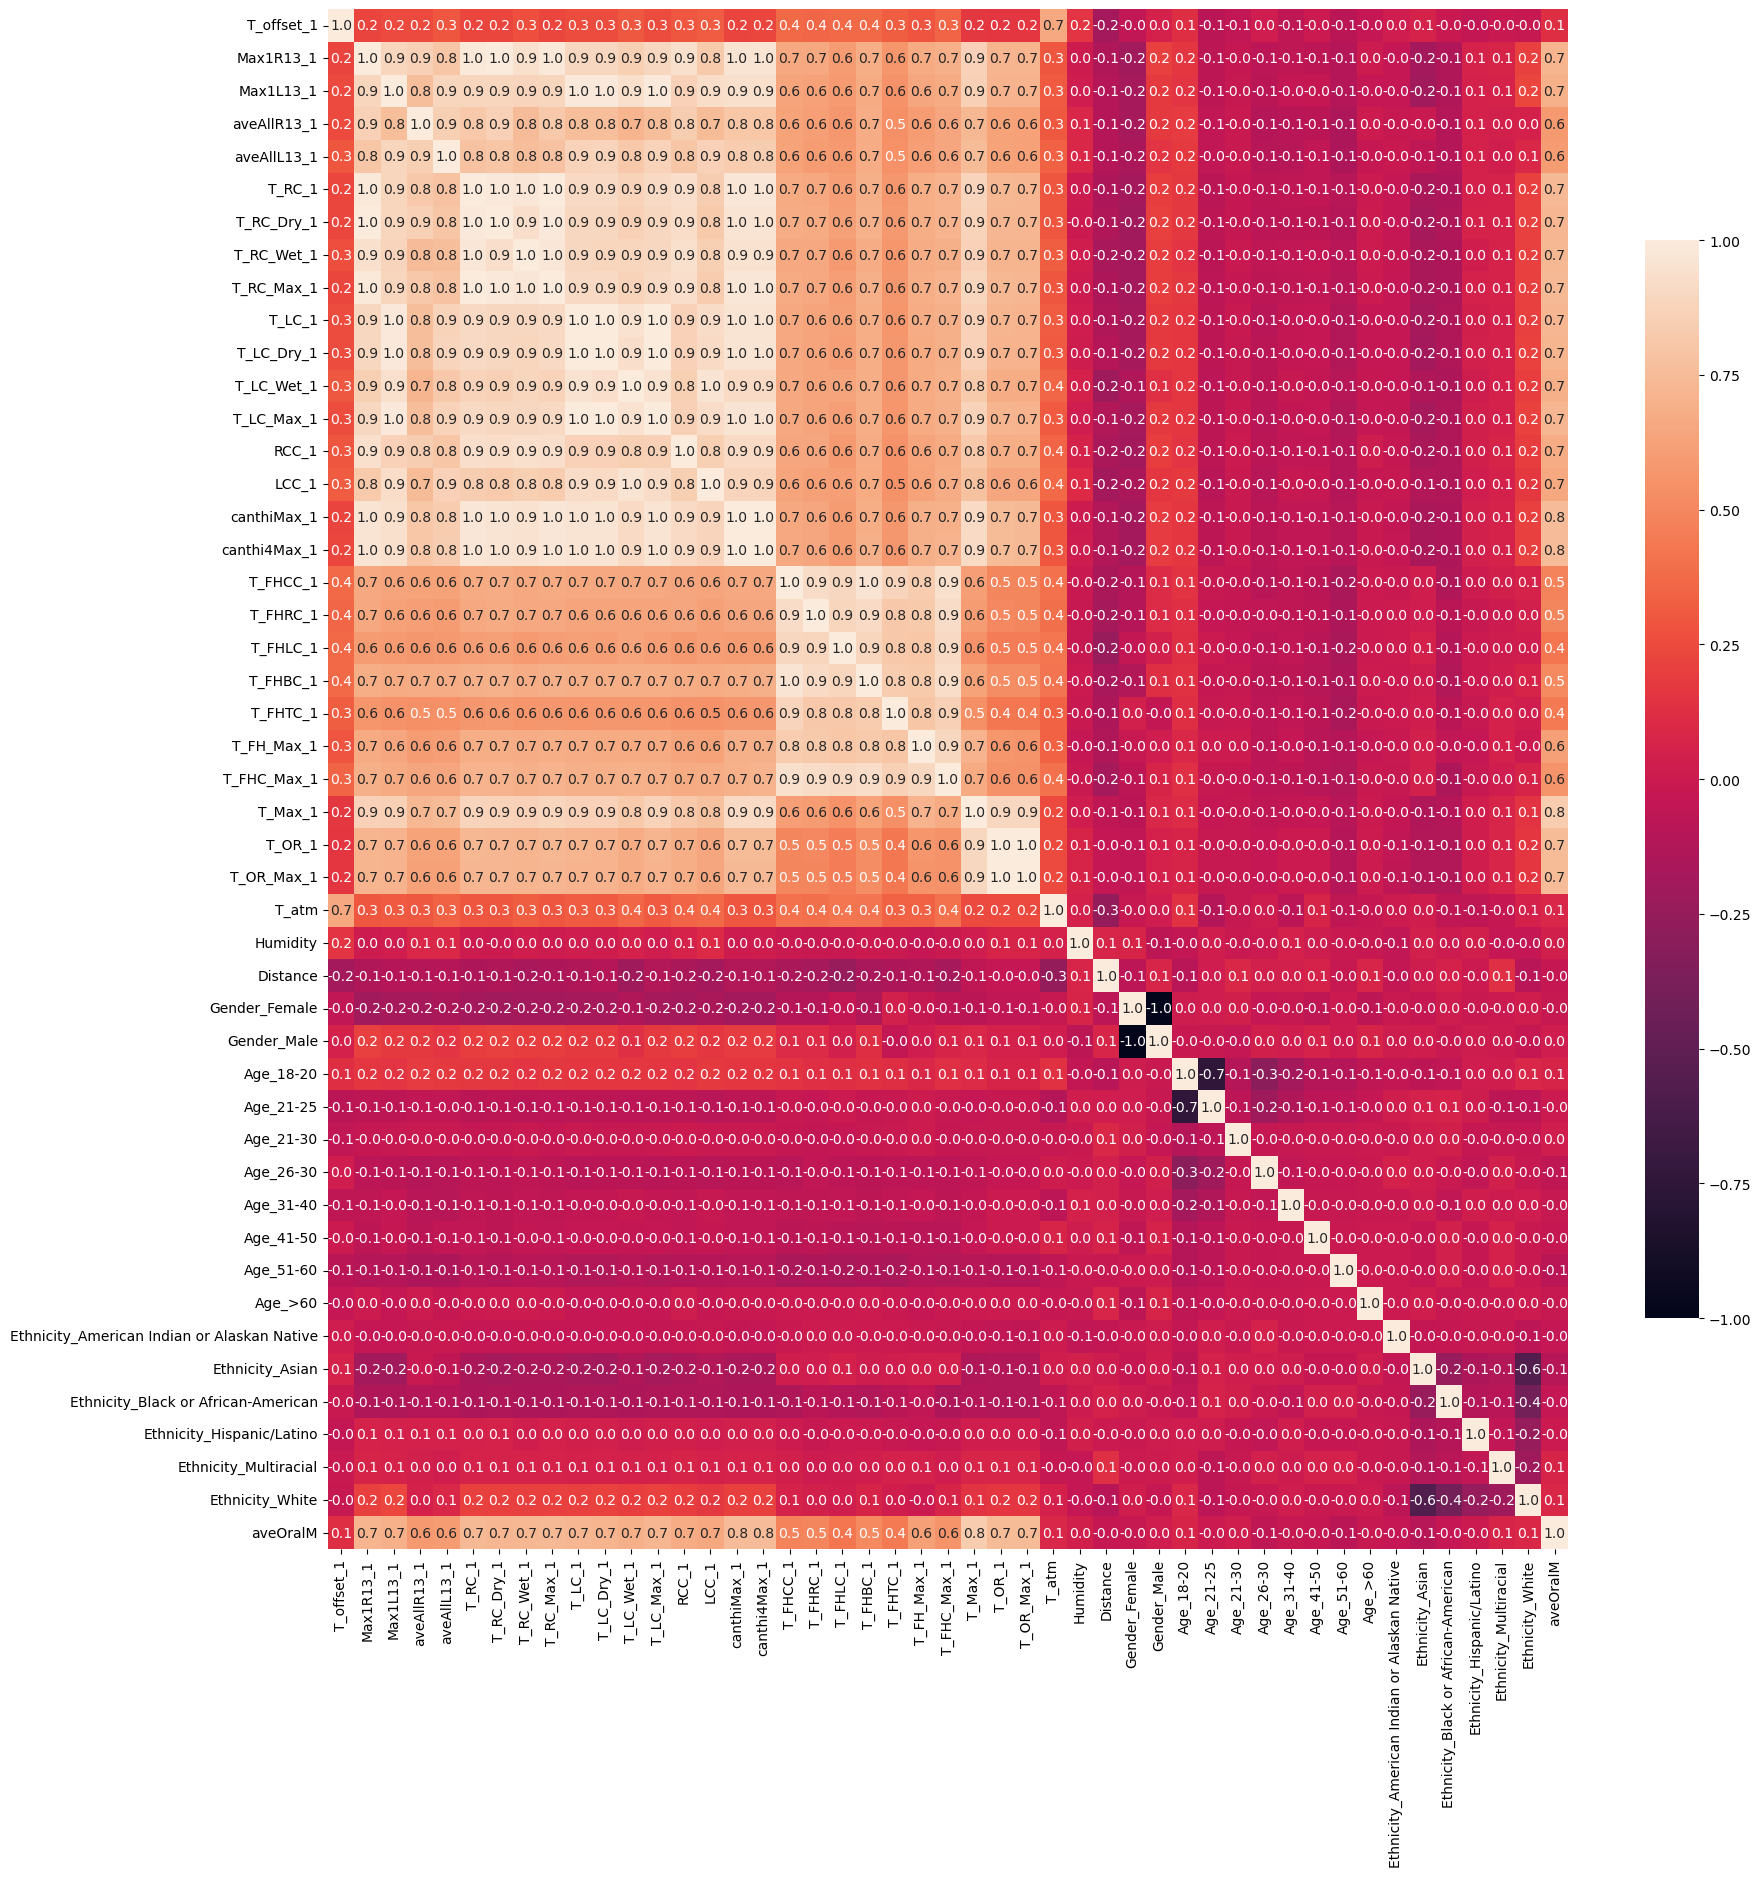

In [77]:
# Correlation Matrix
plt.figure(figsize=(20, 20))
corrMatrix = final_dataset.corr()
sns.heatmap(corrMatrix, annot=True, fmt=".1f", cbar_kws={"shrink": 0.7})

#### Training model on entire dataset

In [84]:
x_train.shape

(568, 46)

In [78]:
model_test_prediction = LinReg(x_train, y_train, x_val, y_val) # train linear regression model

mse_all, r_mse_all, mae_all = compute_metrics(y_val, model_test_prediction) # calculate metrics

print("Mean Squared Error for all features: ", mse_all)
print("Root Mean Squared Error for all features: ", r_mse_all)
print("Mean Absolute Error for all features: ", mae_all)

Mean Squared Error for all features:  0.06689753989312343
Root Mean Squared Error for all features:  0.2586455874224871
Mean Absolute Error for all features:  0.20856296883028932


### Feature Reduction/Selection

In [79]:
#Polynomial Feature Mapping



In [80]:
#Feature Reduction using Sequential Backward Feature Selection
def seq_back_feat_select(model_reduce, n_features_to_select, direction):

    # Create a SequentialFeatureSelector object for backward selection
    sfs_backward = SequentialFeatureSelector(estimator=model_reduce, n_features_to_select=n_features_to_select, direction=direction)
    sfs_backward.fit(x_train, y_train)

    # Get the names of selected features
    selected_features_backward = x_train.columns[sfs_backward.support_]
    
    return selected_features_backward 

In [81]:
# perform sequential feature selection for various number of features and validate the metrics each epoch
num_feats = x_train.shape[1]
feature_select_mse = []

for i in range(num_feats-1,0,-1):
    # print(f"Number of features: {i}")
    selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'backward')

    #extract features from x_train and x_val
    x_train_select_features = x_train[selected_features_backward].copy()
    x_val_select_features = x_val[selected_features_backward].copy()

    model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
    mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

    feature_select_mse.append(mse_sf)

KeyboardInterrupt: 

In [ ]:
reversed_list = list(feature_select_mse)  # Make a copy of the list
reversed_list.reverse()  # Reverse the copy of the list

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(reversed_list, marker='o', linestyle='-')
plt.title('Sequential Feature Selection MSE')
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()


Number of features: 1
Number of features: 2
Number of features: 3
Number of features: 4
Number of features: 5
Number of features: 6
Number of features: 7
Number of features: 8
Number of features: 9
Number of features: 10
Number of features: 11
Number of features: 12
Number of features: 13
Number of features: 14
Number of features: 15
Number of features: 16
Number of features: 17
Number of features: 18
Number of features: 19
Number of features: 20
Number of features: 21
Number of features: 22
Number of features: 23
Number of features: 24
Number of features: 25
Number of features: 26
Number of features: 27
Number of features: 28
Number of features: 29
Number of features: 30
Number of features: 31
New features compared to the last iteration: ['canthiMax_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Wet_1', 'T_LC_Max_1', 'LCC_1',
       'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FH_Max_1',

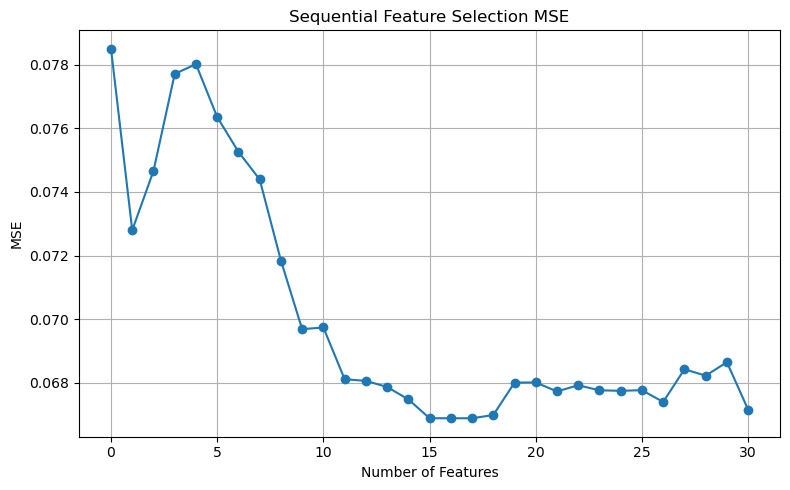

Number of features: 32
New features compared to the last iteration: ['T_LC_Dry_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FH_Max_1', 'T_Max_1', 'T_atm', 'Humidity', 'Gender_Female',
       'Gender_Male', 'Age_18-20', 'Age_21-30', 'Age_26-30', 'Age_41-50',
       'Age_51-60', 'Age_>60', 'Ethnicity_American Indian or Alaskan Native',
       'Ethnicity_Asian', 'Ethnicity_Hispanic/Latino', 'Ethnicity_White'],
      dtype='object')


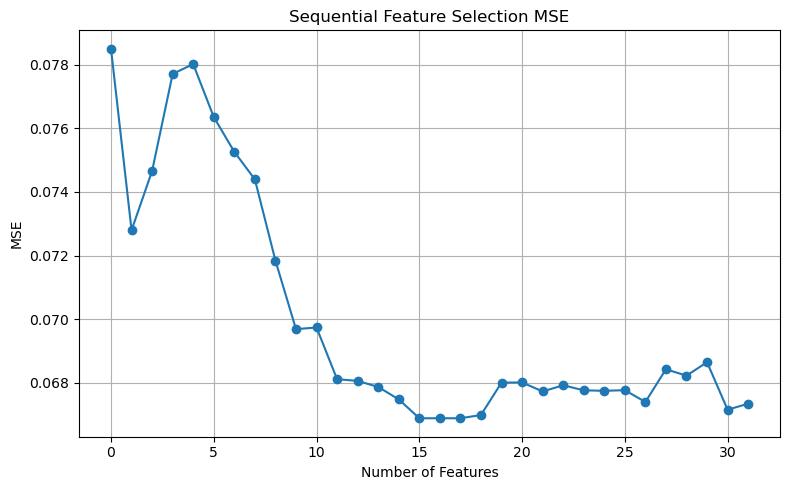

Number of features: 33
New features compared to the last iteration: ['Distance']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FH_Max_1', 'T_Max_1', 'T_atm', 'Humidity', 'Distance',
       'Gender_Female', 'Gender_Male', 'Age_18-20', 'Age_21-30', 'Age_26-30',
       'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Hispanic/Latino', 'Ethnicity_White'],
      dtype='object')


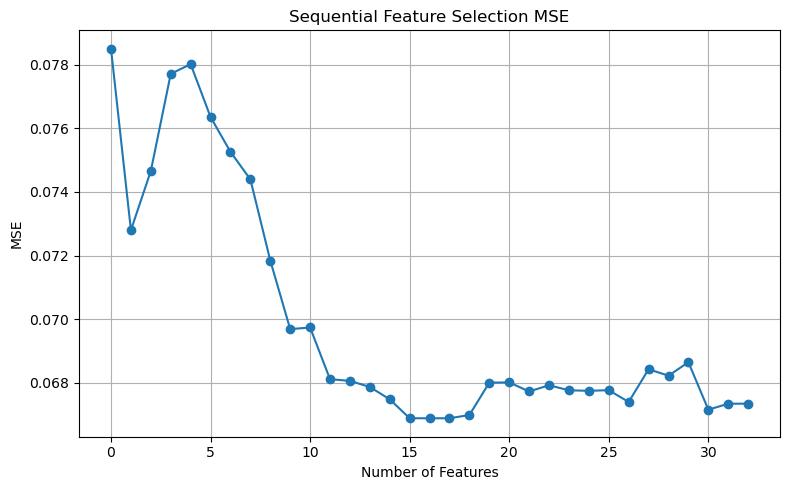

Number of features: 34
New features compared to the last iteration: ['T_FHTC_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_atm', 'Humidity', 'Distance',
       'Gender_Female', 'Gender_Male', 'Age_18-20', 'Age_21-30', 'Age_26-30',
       'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Hispanic/Latino', 'Ethnicity_White'],
      dtype='object')


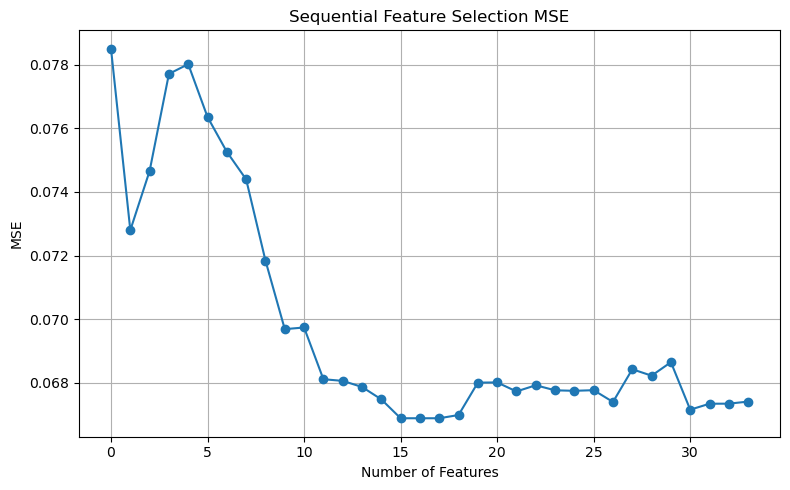

Number of features: 35
New features compared to the last iteration: ['Age_21-25']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_atm', 'Humidity', 'Distance',
       'Gender_Female', 'Gender_Male', 'Age_18-20', 'Age_21-25', 'Age_21-30',
       'Age_26-30', 'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Hispanic/Latino', 'Ethnicity_White'],
      dtype='object')


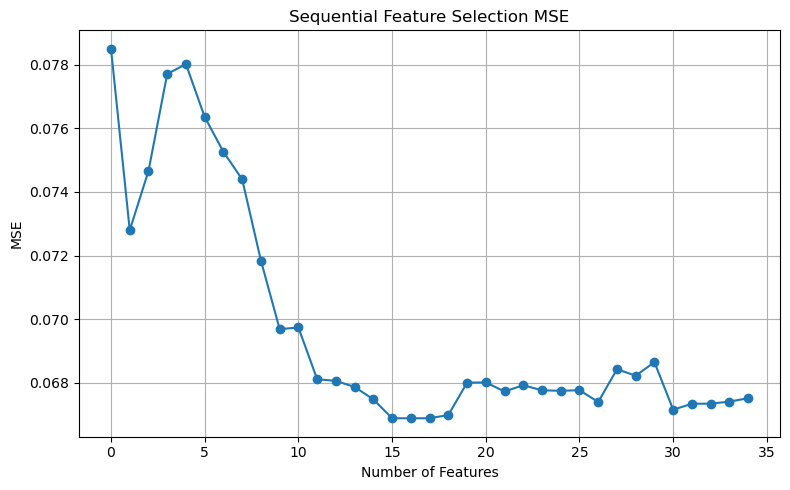

Number of features: 36
New features compared to the last iteration: ['Age_31-40']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_atm', 'Humidity', 'Distance',
       'Gender_Female', 'Gender_Male', 'Age_18-20', 'Age_21-25', 'Age_21-30',
       'Age_26-30', 'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Hispanic/Latino', 'Ethnicity_White'],
      dtype='object')


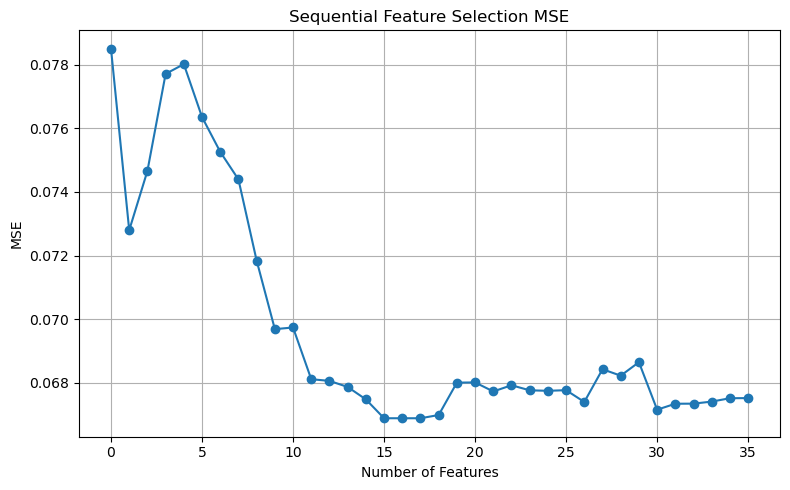

Number of features: 37
New features compared to the last iteration: ['T_OR_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_OR_1', 'T_atm', 'Humidity',
       'Distance', 'Gender_Female', 'Gender_Male', 'Age_18-20', 'Age_21-25',
       'Age_21-30', 'Age_26-30', 'Age_31-40', 'Age_41-50', 'Age_51-60',
       'Age_>60', 'Ethnicity_American Indian or Alaskan Native',
       'Ethnicity_Asian', 'Ethnicity_Hispanic/Latino', 'Ethnicity_White'],
      dtype='object')


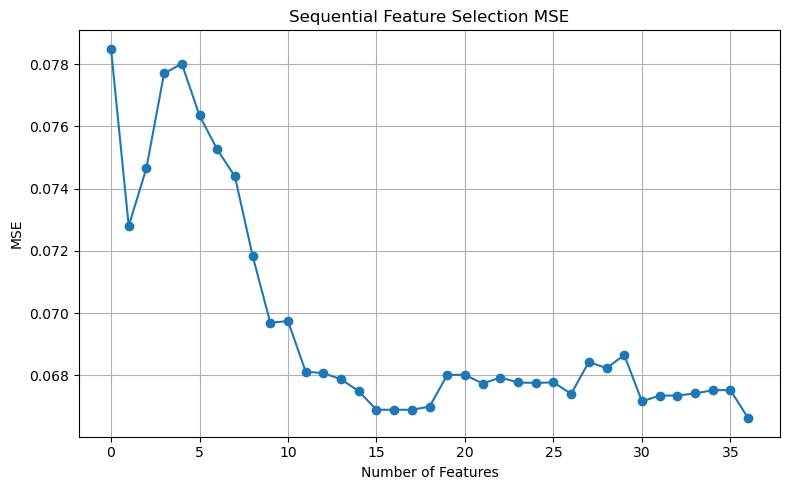

Number of features: 38
New features compared to the last iteration: ['T_OR_Max_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_OR_1', 'T_OR_Max_1', 'T_atm',
       'Humidity', 'Distance', 'Gender_Female', 'Gender_Male', 'Age_18-20',
       'Age_21-25', 'Age_21-30', 'Age_26-30', 'Age_31-40', 'Age_41-50',
       'Age_51-60', 'Age_>60', 'Ethnicity_American Indian or Alaskan Native',
       'Ethnicity_Asian', 'Ethnicity_Hispanic/Latino', 'Ethnicity_White'],
      dtype='object')


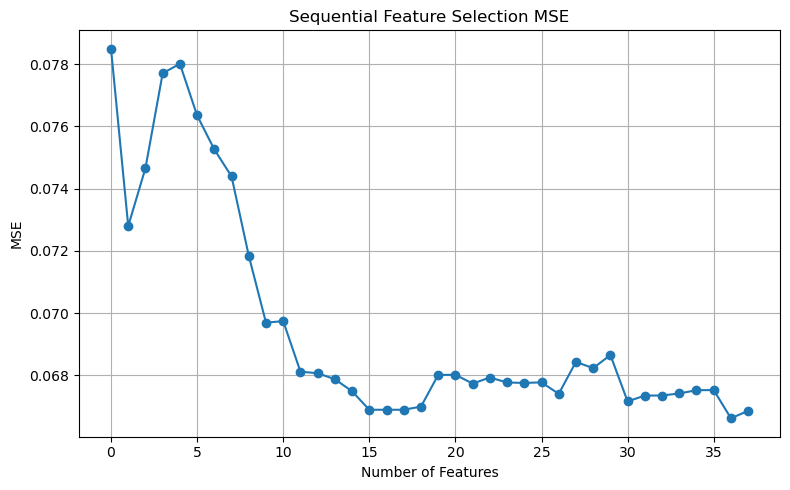

Number of features: 39
New features compared to the last iteration: ['Ethnicity_Multiracial']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_OR_1', 'T_OR_Max_1', 'T_atm',
       'Humidity', 'Distance', 'Gender_Female', 'Gender_Male', 'Age_18-20',
       'Age_21-25', 'Age_21-30', 'Age_26-30', 'Age_31-40', 'Age_41-50',
       'Age_51-60', 'Age_>60', 'Ethnicity_American Indian or Alaskan Native',
       'Ethnicity_Asian', 'Ethnicity_Hispanic/Latino', 'Ethnicity_Multiracial',
       'Ethnicity_White'],
      dtype='object')


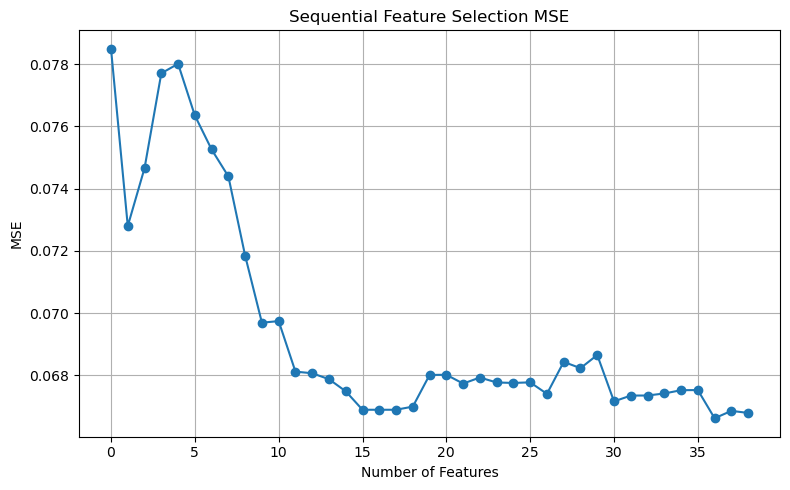

Number of features: 40
New features compared to the last iteration: ['Ethnicity_Black or African-American']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_OR_1', 'T_OR_Max_1', 'T_atm',
       'Humidity', 'Distance', 'Gender_Female', 'Gender_Male', 'Age_18-20',
       'Age_21-25', 'Age_21-30', 'Age_26-30', 'Age_31-40', 'Age_41-50',
       'Age_51-60', 'Age_>60', 'Ethnicity_American Indian or Alaskan Native',
       'Ethnicity_Asian', 'Ethnicity_Black or African-American',
       'Ethnicity_Hispanic/Latino', 'Ethnicity_Multiracial',
       'Ethnicity_White'],
      dtype='object')


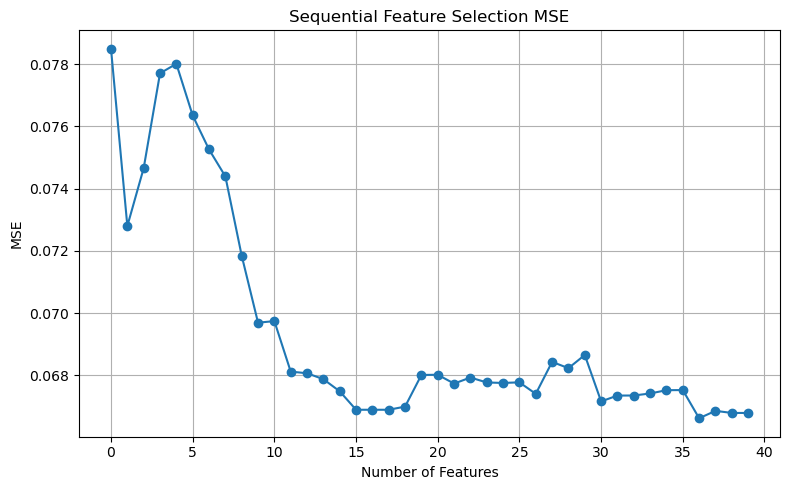

Number of features: 41
New features compared to the last iteration: ['RCC_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllL13_1', 'T_RC_Dry_1', 'T_RC_Wet_1',
       'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1', 'T_LC_Max_1',
       'RCC_1', 'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1',
       'T_FHBC_1', 'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_OR_1', 'T_OR_Max_1',
       'T_atm', 'Humidity', 'Distance', 'Gender_Female', 'Gender_Male',
       'Age_18-20', 'Age_21-25', 'Age_21-30', 'Age_26-30', 'Age_31-40',
       'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Black or African-American', 'Ethnicity_Hispanic/Latino',
       'Ethnicity_Multiracial', 'Ethnicity_White'],
      dtype='object')


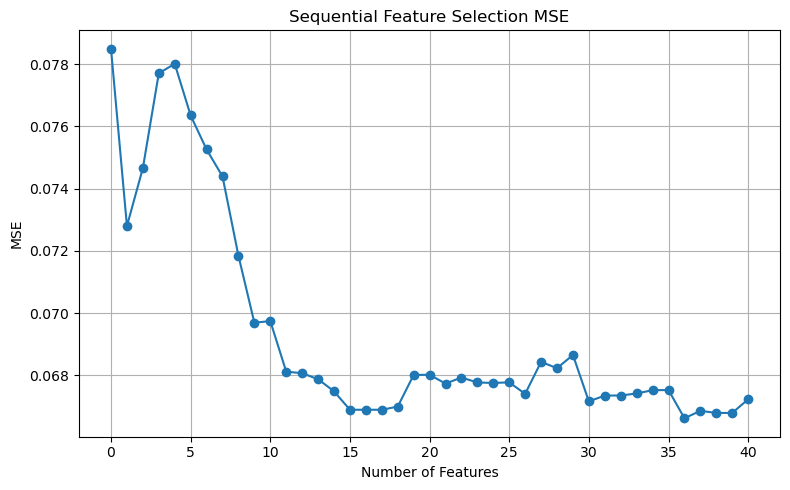

Number of features: 42
New features compared to the last iteration: ['aveAllR13_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC_Dry_1',
       'T_RC_Wet_1', 'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1',
       'T_LC_Max_1', 'RCC_1', 'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1',
       'T_FHLC_1', 'T_FHBC_1', 'T_FHTC_1', 'T_FH_Max_1', 'T_Max_1', 'T_OR_1',
       'T_OR_Max_1', 'T_atm', 'Humidity', 'Distance', 'Gender_Female',
       'Gender_Male', 'Age_18-20', 'Age_21-25', 'Age_21-30', 'Age_26-30',
       'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Black or African-American', 'Ethnicity_Hispanic/Latino',
       'Ethnicity_Multiracial', 'Ethnicity_White'],
      dtype='object')


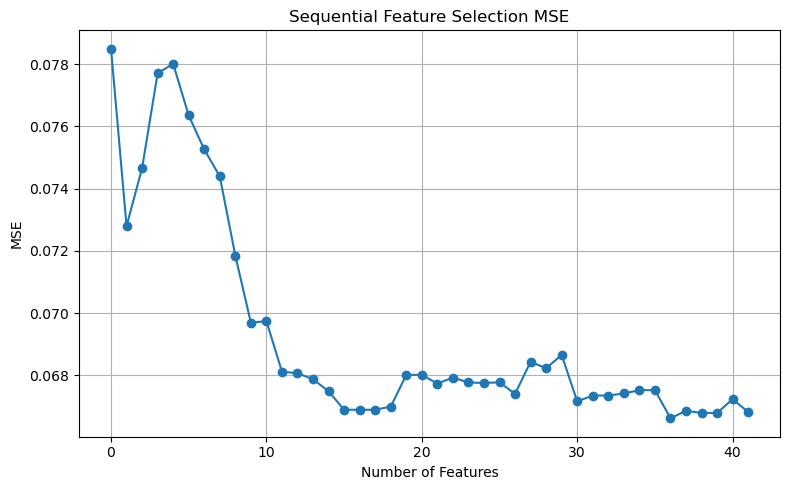

Number of features: 43
New features compared to the last iteration: ['T_FHC_Max_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC_Dry_1',
       'T_RC_Wet_1', 'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1',
       'T_LC_Max_1', 'RCC_1', 'LCC_1', 'canthiMax_1', 'T_FHCC_1', 'T_FHRC_1',
       'T_FHLC_1', 'T_FHBC_1', 'T_FHTC_1', 'T_FH_Max_1', 'T_FHC_Max_1',
       'T_Max_1', 'T_OR_1', 'T_OR_Max_1', 'T_atm', 'Humidity', 'Distance',
       'Gender_Female', 'Gender_Male', 'Age_18-20', 'Age_21-25', 'Age_21-30',
       'Age_26-30', 'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Black or African-American', 'Ethnicity_Hispanic/Latino',
       'Ethnicity_Multiracial', 'Ethnicity_White'],
      dtype='object')


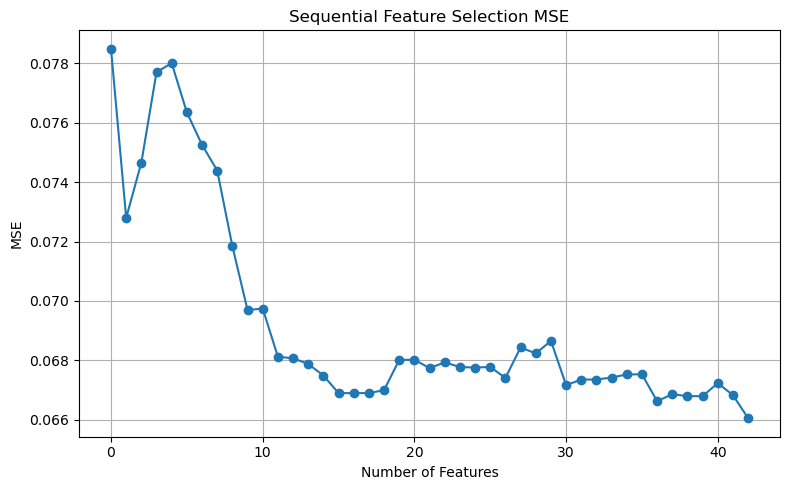

Number of features: 44
New features compared to the last iteration: ['canthi4Max_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC_Dry_1',
       'T_RC_Wet_1', 'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1', 'T_LC_Wet_1',
       'T_LC_Max_1', 'RCC_1', 'LCC_1', 'canthiMax_1', 'canthi4Max_1',
       'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1', 'T_FHTC_1',
       'T_FH_Max_1', 'T_FHC_Max_1', 'T_Max_1', 'T_OR_1', 'T_OR_Max_1', 'T_atm',
       'Humidity', 'Distance', 'Gender_Female', 'Gender_Male', 'Age_18-20',
       'Age_21-25', 'Age_21-30', 'Age_26-30', 'Age_31-40', 'Age_41-50',
       'Age_51-60', 'Age_>60', 'Ethnicity_American Indian or Alaskan Native',
       'Ethnicity_Asian', 'Ethnicity_Black or African-American',
       'Ethnicity_Hispanic/Latino', 'Ethnicity_Multiracial',
       'Ethnicity_White'],
      dtype='object')


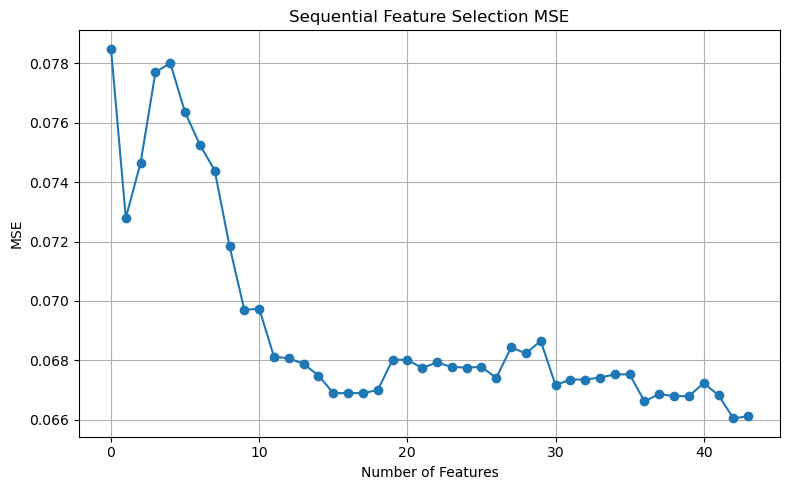

Number of features: 45
New features compared to the last iteration: ['T_RC_1']
Index(['T_offset_1', 'Max1R13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC_1',
       'T_RC_Dry_1', 'T_RC_Wet_1', 'T_RC_Max_1', 'T_LC_1', 'T_LC_Dry_1',
       'T_LC_Wet_1', 'T_LC_Max_1', 'RCC_1', 'LCC_1', 'canthiMax_1',
       'canthi4Max_1', 'T_FHCC_1', 'T_FHRC_1', 'T_FHLC_1', 'T_FHBC_1',
       'T_FHTC_1', 'T_FH_Max_1', 'T_FHC_Max_1', 'T_Max_1', 'T_OR_1',
       'T_OR_Max_1', 'T_atm', 'Humidity', 'Distance', 'Gender_Female',
       'Gender_Male', 'Age_18-20', 'Age_21-25', 'Age_21-30', 'Age_26-30',
       'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_>60',
       'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
       'Ethnicity_Black or African-American', 'Ethnicity_Hispanic/Latino',
       'Ethnicity_Multiracial', 'Ethnicity_White'],
      dtype='object')


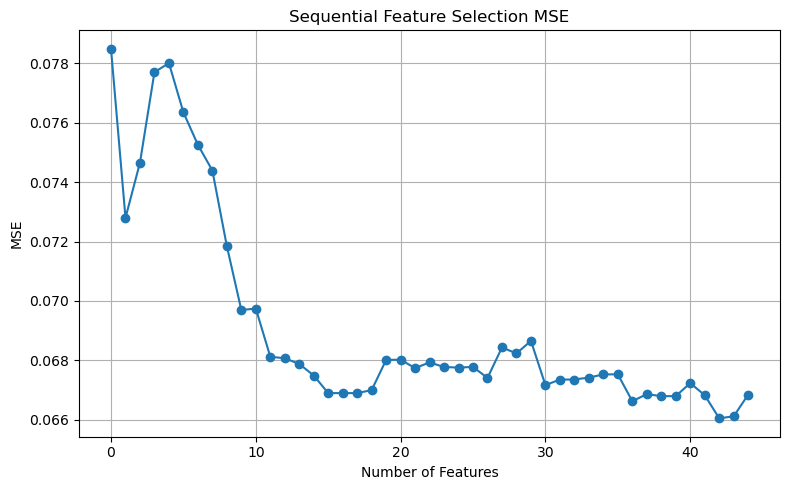

In [83]:
num_feats = x_train.shape[1]
feature_select_mse = []

old_features = []

for i in range(1, num_feats):
    print(f"Number of features: {i}")
    selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'forward')

    #extract features from x_train and x_val
    x_train_select_features = x_train[selected_features_backward].copy()
    x_val_select_features = x_val[selected_features_backward].copy()

    model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
    mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

    feature_select_mse.append(mse_sf)

    if i>30:
        new_features = [feat for feat in selected_features_backward if feat not in old_features]
        print(f"New features compared to the last iteration: {new_features}")

        print(selected_features_backward)
        plt.figure(figsize=(8, 5))
        plt.plot(feature_select_mse, marker='o', linestyle='-')
        plt.title('Sequential Feature Selection MSE')
        plt.xlabel('Number of Features')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    old_features = selected_features_backward

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(feature_select_mse, marker='o', linestyle='-')
plt.title('Sequential Feature Selection MSE')
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
num_feats = x_train.shape[1]
feature_select_mse = []

for i in range(num_feats,1,-1):
    # print(f"Number of features: {i}")
    selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'backward')

    #extract features from x_train and x_val
    x_train_select_features = x_train[selected_features_backward].copy()
    x_val_select_features = x_val[selected_features_backward].copy()

    model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
    mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

    feature_select_mse.append(mse_sf)

In [41]:
reversed_list = list(feature_select_mse)  # Make a copy of the list
reversed_list.reverse()  # Reverse the copy of the list

reversed_list  # Print the reversed list

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(reversed_list, marker='o', linestyle='-')
plt.title('Sequential Feature Selection MSE')
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
num_feats = x_train.shape[1]
feature_select_mse = []

for i in range(1, num_feats):
    # print(f"Number of features: {i}")
    selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'forward')

    #extract features from x_train and x_val
    x_train_select_features = x_train[selected_features_backward].copy()
    x_val_select_features = x_val[selected_features_backward].copy()

    model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
    mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

    feature_select_mse.append(mse_sf)

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(feature_select_mse, marker='o', linestyle='-')
plt.title('Sequential Feature Selection MSE')
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
selected_features_backward = seq_back_feat_select(LinearRegression(), 26, 'backward')

#extract features from x_train and x_val
x_train_select_features = x_train[selected_features_backward].copy()
x_val_select_features = x_val[selected_features_backward].copy()

In [ ]:
full_dataset_reduced = np.concatenate((x_train_select_features, x_val_select_features), axis=0)
full_dataset_reduced = pd.DataFrame(full_dataset_reduced)
print(type(full_dataset_reduced))
print(full_dataset_reduced.shape)
# print(x_val_select_features.shape)


<class 'pandas.core.frame.DataFrame'>
(710, 26)


In [ ]:
full_dataset_reduced

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.9125,36.135,35.37,36.0975,35.6225,35.6225,35.3775,35.65,35.7675,35.3625,...,36.2825,23.6,False,True,False,False,False,False,False,False
1,1.1625,35.3775,34.9475,35.3175,35.5125,35.4375,35.5125,35.53,35.265,35.21,...,36.1025,23.8,True,False,False,False,False,False,False,False
2,0.8375,35.99,35.505,36.0275,36.17,36.0625,36.0325,36.21,35.7525,35.8325,...,36.24,22.9,True,False,False,False,False,False,False,True
3,1.3925,35.5175,35.1775,35.4825,35.0175,35.005,34.9575,35.0475,35.1975,34.7925,...,35.7475,24.0,False,True,False,False,False,False,False,False
4,0.7925,35.1825,34.2425,35.175,35.1125,35.1025,35.0775,35.13,34.81,34.6175,...,35.69,24.0,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,1.475,35.9225,35.5125,35.9,36.0825,36.0825,35.6425,36.145,35.6375,35.545,...,36.2725,22.0,False,True,False,False,False,False,True,False
706,0.7175,35.5875,34.735,35.5775,35.7075,35.7075,35.27,35.745,34.6725,35.1075,...,36.0325,23.2,True,False,False,False,False,False,False,True
707,0.776459,35.820036,35.180994,35.781867,35.580597,35.574414,35.279527,35.615528,35.40286,35.129774,...,36.252114,23.2,True,False,False,False,False,False,False,True
708,1.0175,35.4925,35.06,35.475,35.56,35.4925,35.4725,35.615,35.16,35.3325,...,36.4625,25.1,True,False,False,False,False,False,False,True


### Feature Construction/Feature Engineering

In [ ]:
### need to get a better understanding of the features they give us and based off that, then generate a few of our own
# use non linear and linear engineered features

In [ ]:
norm_full_dataset_reduced = (full_dataset_reduced - full_dataset_reduced.mean()) / full_dataset_reduced.std()
# norm_dataset_reduced_df = pd.DataFrame(norm_dataset_reduced)
print(norm_full_dataset_reduced.shape)
type(norm_full_dataset_reduced)

(710, 26)


pandas.core.frame.DataFrame

In [ ]:
norm_full_dataset_reduced

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.099285,1.069021,0.748707,1.025402,0.054734,0.106046,-0.055828,0.049236,0.998332,0.383706,...,0.482715,-0.231751,-1.202596,1.202596,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,-0.996485
1,0.641494,-0.342974,0.123953,-0.440196,-0.162673,-0.25512,0.199425,-0.188078,0.098006,0.10827,...,0.094109,-0.08464,0.830364,-0.830364,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,-0.996485
2,-0.321519,0.798738,0.948333,0.893874,1.136829,0.965037,1.182625,1.156697,0.971456,1.232589,...,0.390961,-0.746637,0.830364,-0.830364,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,1.002114
3,1.32301,-0.082011,0.464056,-0.130166,-1.141005,-1.099469,-0.849951,-1.142274,-0.022934,-0.645791,...,-0.672308,0.06247,-1.202596,1.202596,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,-0.996485
4,-0.454859,-0.706457,-0.918537,-0.707949,-0.953244,-0.909124,-0.623059,-0.979121,-0.717215,-0.961864,...,-0.796446,0.06247,-1.202596,1.202596,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,1.002114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,1.567467,0.672917,0.959423,0.654305,0.963891,1.004082,0.445225,1.028153,0.765412,0.713325,...,0.461125,-1.408633,-1.202596,1.202596,-0.106677,-0.286707,-0.099716,-0.053112,4.036594,-0.996485
706,-0.677093,0.04847,-0.190273,0.048337,0.222731,0.271988,-0.259086,0.237109,-0.963573,-0.076858,...,-0.057015,-0.525971,0.830364,-0.830364,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,1.002114
707,-0.50239,0.481922,0.469223,0.432336,-0.028084,0.012171,-0.241073,-0.018937,0.345009,-0.036628,...,0.417114,-0.525971,0.830364,-0.830364,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,1.002114
708,0.211842,-0.128611,0.290307,-0.144258,-0.068793,-0.147746,0.123795,-0.019981,-0.090122,0.329522,...,0.87132,0.871577,0.830364,-0.830364,-0.106677,-0.286707,-0.099716,-0.053112,-0.247385,1.002114


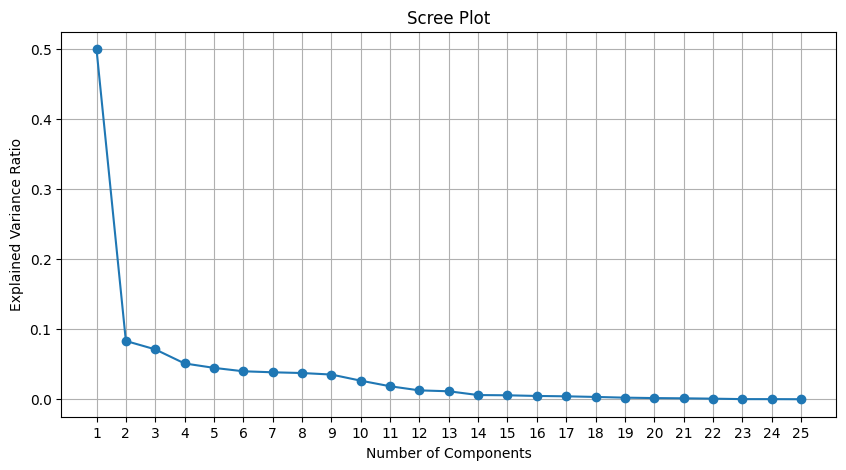

In [ ]:
#PCA on entire dataset with reduced features

num_components = np.arange(1, 26)
pca = PCA(n_components=26)  
pca.fit(norm_full_dataset_reduced)

plt.figure(figsize=(10, 5))  
explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(num_components, explained_variance_ratio[:25], marker='o', linestyle='-')  
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(num_components)
plt.grid(True)
plt.show() 

### Final Data Preprocessing

1. perform PCA on all the feature reduced and engineered features (both train and validation, dont pca the labels)
2. final train test split

In [ ]:
# num_components = XXXXXXXXXXXXX
pca_dataset_reduced = PCA(n_components=13)
pca_transform = pca_dataset_reduced.fit_transform(norm_full_dataset_reduced)

In [ ]:
y_training_data_norm = (y_training_data - y_training_data.mean()) / y_training_data.std() # shouldnt need to do this

In [ ]:
#split data into test and validation sets
y_training_data_reshaped = y_training_data_norm.values.reshape(-1, 1)
final_dataset_x = pca_transform

# X_training_data = final_dataset.iloc[:, :-1]  # Features
# y_training_data = final_dataset.iloc[:, -1]   # Labels

x_train, x_val, y_train, y_val = train_test_split(final_dataset_x, y_training_data_reshaped, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(568, 13)
(142, 13)
(568, 1)
(142, 1)


### Model Training and Validation

#### Trivial Solution

##### Mean Output Value

In [ ]:
# A system that always outputs the mean output value y_pred from the training set. 
y_pred = y_train.mean()
y_pred_triv = np.array([y_pred]*len(y_val))
mse, r_mse, mae = compute_metrics(y_val, y_pred_triv)



print("Label means: ", y_pred)
print("Mean Squared Error for all features: ", mse)
print("Root Mean Squared Error for all features: ", r_mse)
print("Mean Absolute Error for all features: ", mae)

Label means:  -0.016273543029925782
Mean Squared Error for all features:  1.1059117016648914
Root Mean Squared Error for all features:  1.051623364929142
Mean Absolute Error for all features:  0.6695017221793498


In [ ]:
print(y_pred)
print(y_pred_triv.shape)

-0.016273543029925782
(142,)


#### Baseline Models

##### Linear Regression (No Regularisation)

In [ ]:
model_test_prediction = LinReg(x_train, y_train, x_val, y_val) # train linear regression model

mse_all, r_mse_all, mae_all = compute_metrics(y_val, model_test_prediction) # calculate metrics

print("Mean Squared Error for all features: ", mse_all)
print("Root Mean Squared Error for all features: ", r_mse_all)
print("Mean Absolute Error for all features: ", mae_all)

Mean Squared Error for all features:  1.1683731688212966
Root Mean Squared Error for all features:  1.080913118072538
Mean Absolute Error for all features:  0.6769362976693315


##### 1NN

In [ ]:
#RH

def Nearest_Neighbors(train_data, train_label, val_data, val_label, k_val):
    knn = KNeighborsRegressor(n_neighbors = k_val)

    knn.fit(train_data, train_label)

    predictions = knn.predict(val_data)

    return predictions

In [ ]:
one_NN_pred = Nearest_Neighbors(x_train, y_train, x_val, y_val, 1)

mse_oneNN, r_mse_oneNN, mae_oneNN = compute_metrics(y_val, one_NN_pred) # calculate metrics for 1 NN

print("Mean Squared Error for all features: ", mse_oneNN)
print("Root Mean Squared Error for all features: ", r_mse_oneNN)
print("Mean Absolute Error for all features: ", mae_oneNN)

Mean Squared Error for all features:  1.8409276651322977
Root Mean Squared Error for all features:  1.356807895441465
Mean Absolute Error for all features:  0.9475459866205981


#### In-Class Regression Models

##### Ridge Regression

In [ ]:
#RH

def ridge_regression(train_data, train_label, val_data, val_label, lambda_val):
    rr_model = Ridge(alpha=lambda_val)
    rr_model.fit(train_data, train_label)

    # Predicting on the test set
    rr_pred = rr_model.predict(val_data)

    return rr_pred



In [ ]:
# lambda_values = [0.001, 0.005, 0.01, 0.1, 1, 5, 10, 100, 1000, 10000]
lambda_values = [1,2,3,4,5,6,7,8,9,10]

mse_rr_values = []
r_mse_rr_values = []
mae_rr_values = []

for i in lambda_values:
    rr_predictions = ridge_regression(x_train, y_train, x_val, y_val, i)

    mse_rr, r_mse_rr, mae_rr = compute_metrics(y_val, rr_predictions)

    mse_rr_values.append(mse_rr)
    r_mse_rr_values.append(r_mse_rr)
    mae_rr_values.append(mae_rr)

    print("Mean Squared Error for lambda =", i, ":", mse_rr)
    print("Root Mean Squared Error for lambda =", i, ":", r_mse_rr)
    print("Mean Absolute Error for lambda =", i, ":", mae_rr)
    print("")


Mean Squared Error for lambda = 1 : 1.168067838679784
Root Mean Squared Error for lambda = 1 : 1.0807718717101145
Mean Absolute Error for lambda = 1 : 0.676887469708517

Mean Squared Error for lambda = 2 : 1.1677661283952836
Root Mean Squared Error for lambda = 2 : 1.0806322817662277
Mean Absolute Error for lambda = 2 : 0.6768389011139273

Mean Squared Error for lambda = 3 : 1.1674679694171002
Root Mean Squared Error for lambda = 3 : 1.0804943171609465
Mean Absolute Error for lambda = 3 : 0.6767905898226089

Mean Squared Error for lambda = 4 : 1.1671732949643734
Root Mean Squared Error for lambda = 4 : 1.0803579476101304
Mean Absolute Error for lambda = 4 : 0.6767425337857185

Mean Squared Error for lambda = 5 : 1.1668820399685973
Root Mean Squared Error for lambda = 5 : 1.0802231435997829
Mean Absolute Error for lambda = 5 : 0.6766947309687922

Mean Squared Error for lambda = 6 : 1.1665941410183833
Root Mean Squared Error for lambda = 6 : 1.0800898763613995
Mean Absolute Error for lam

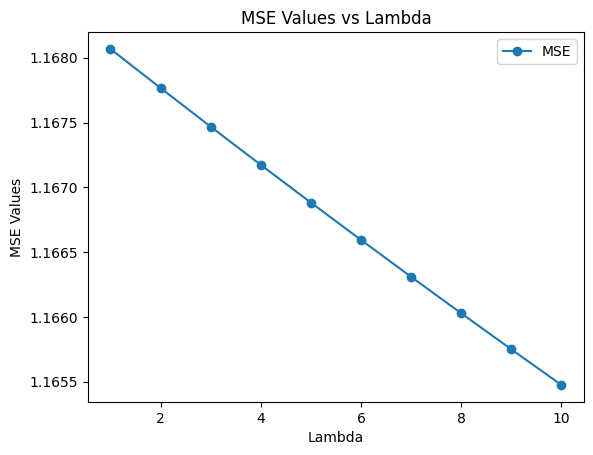

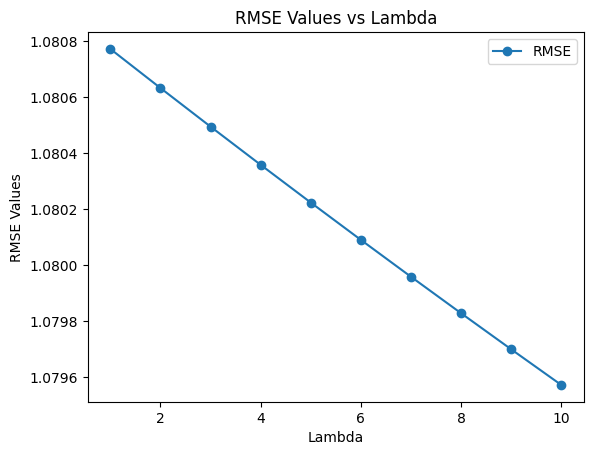

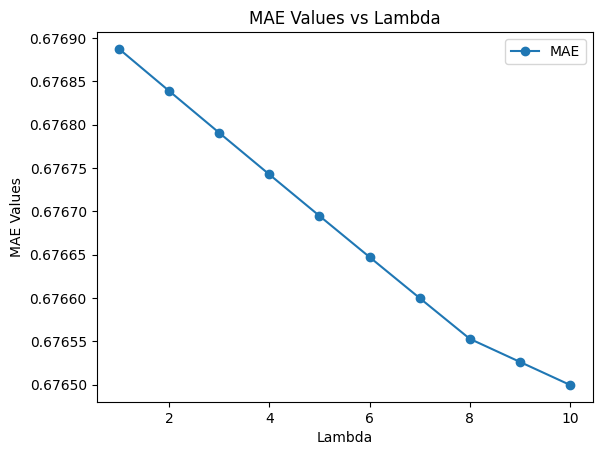

In [ ]:
# Plotting MSE for Ridge Regression
plt.plot(lambda_values, mse_rr_values, label='MSE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('MSE Values')
plt.title('MSE Values vs Lambda')
plt.legend()
plt.show()

# Plotting RMSE for Ridge Regression
plt.plot(lambda_values, r_mse_rr_values, label='RMSE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('RMSE Values')
plt.title('RMSE Values vs Lambda')
plt.legend()
plt.show()

# Plotting MAE for Ridge Regression
plt.plot(lambda_values, mae_rr_values, label='MAE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('MAE Values')
plt.title('MAE Values vs Lambda')
plt.legend()
plt.show()


##### K-Nearest Neighbours Regression

In [ ]:
#HC

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mse_NN_values = []
r_mse_NN_values = []
mae_NN_values = []

for i in k_values:
    NN_predictions = Nearest_Neighbors(x_train, y_train, x_val, y_val, i)

    mse_NN, r_mse_NN, mae_NN = compute_metrics(y_val, NN_predictions)

    mse_NN_values.append(mse_NN)
    r_mse_NN_values.append(r_mse_NN)
    mae_NN_values.append(mae_NN)

    print("Mean Squared Error for k = ", i, ": ", mse_NN)
    print("Root Mean Squared Error for k = ", i, ": ", r_mse_NN)
    print("Mean Absolute Error for k = ", i, ": ", mae_NN)
    print("")

Mean Squared Error for k =  1 :  1.8409276651322977
Root Mean Squared Error for k =  1 :  1.356807895441465
Mean Absolute Error for k =  1 :  0.9475459866205981

Mean Squared Error for k =  2 :  1.4948616622806283
Root Mean Squared Error for k =  2 :  1.2226453542547113
Mean Absolute Error for k =  2 :  0.8558945469398542

Mean Squared Error for k =  3 :  1.3420447068121217
Root Mean Squared Error for k =  3 :  1.1584665324523284
Mean Absolute Error for k =  3 :  0.8101891045793789

Mean Squared Error for k =  4 :  1.2608169176444888
Root Mean Squared Error for k =  4 :  1.1228610411108264
Mean Absolute Error for k =  4 :  0.775789745329126

Mean Squared Error for k =  5 :  1.1914432377011046
Root Mean Squared Error for k =  5 :  1.0915325179311446
Mean Absolute Error for k =  5 :  0.7550057968030991

Mean Squared Error for k =  6 :  1.1510820590987607
Root Mean Squared Error for k =  6 :  1.0728849235117253
Mean Absolute Error for k =  6 :  0.7403078887598094

Mean Squared Error for k

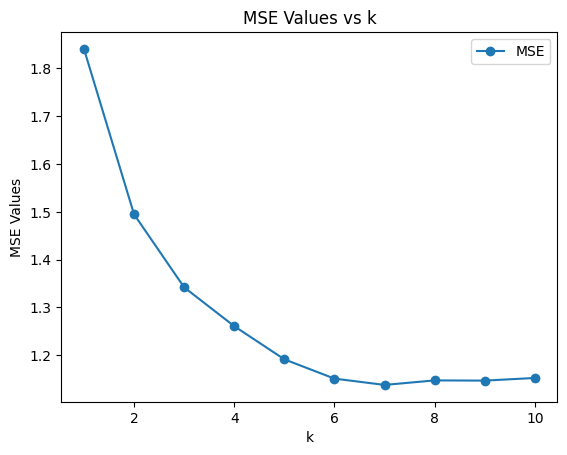

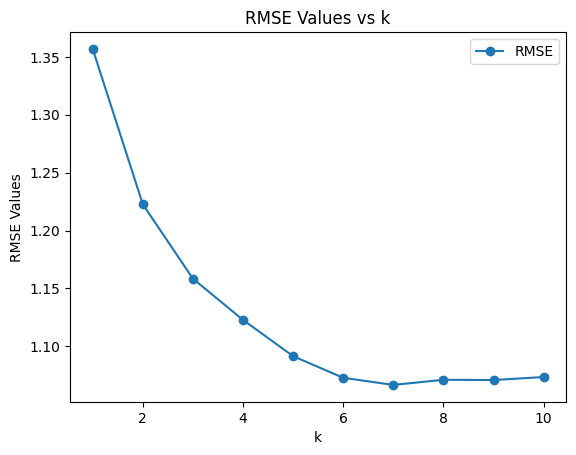

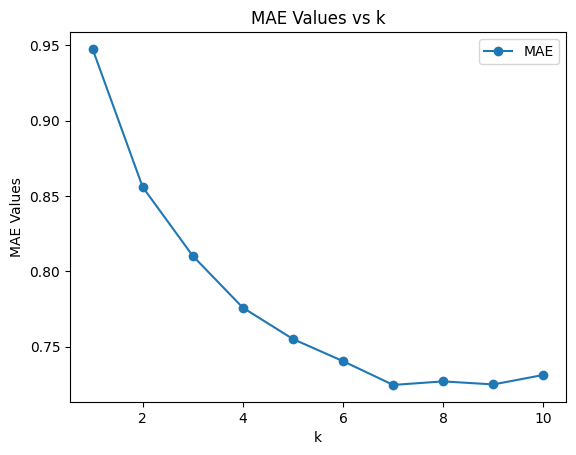

In [ ]:
# Plotting MSE for NN
plt.plot(k_values, mse_NN_values, label='MSE', marker='o')
plt.xlabel('k')
plt.ylabel('MSE Values')
plt.title('MSE Values vs k')
plt.legend()
plt.show()

# Plotting RMSE for NN
plt.plot(k_values, r_mse_NN_values, label='RMSE', marker='o')
plt.xlabel('k')
plt.ylabel('RMSE Values')
plt.title('RMSE Values vs k')
plt.legend()
plt.show()

# Plotting MAE for NN
plt.plot(k_values, mae_NN_values, label='MAE', marker='o')
plt.xlabel('k')
plt.ylabel('MAE Values')
plt.title('MAE Values vs k')
plt.legend()
plt.show()


##### MSE Regression

##### Support Vector Regression (SVR)

In [ ]:
#RH

def svr(train_data, train_label, val_data, val_label, kernel_type, C_value, epsilon_value):
    svr_model = SVR(kernel = kernel_type, C = C_value, epsilon = epsilon_value)

    svr_model.fit(train_data, train_label)

    svr_pred = svr_model.predict(val_data)

    return svr_pred




In [ ]:
kernel_types = ['rbf', 'linear', 'poly', 'sigmoid']

C = 0.1
epsilon = 0.01

# C_values = [0.1, 1, 5, 10]
# epsilon_values = [0.01, 0.1, 0.5, 1]

mse_svr_values = []
r_mse_svr_values = []
mae_svr_values = []

for i in kernel_types:
    svr_predictions = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), i, C, epsilon)

    mse_svr, r_mse_svr, mae_svr = compute_metrics(y_val, svr_predictions)

    print("Mean Squared Error for", i, "Kernel:", mse_svr)
    print("Root Mean Squared Error for", i, "Kernel:", r_mse_svr)
    print("Mean Absolute Error for", i, "Kernel:", mae_svr)
    print("")



# for i in kernel_types:
#     for j in C_values:
#         for k in epsilon_values:
#             svr_predictions = svr(x_train, y_train, x_val, y_val, i, j, k)

#             mse_svr, r_mse_svr, mae_svr = compute_metrics(y_val, svr_predictions)

#             mse_svr_values.append(mse_svr)
#             # r_mse_svr_values.append(r_mse_svr)
#             # mae_svr_values.append(mae_svr)

#             print("Mean Squared Error for Kernel Type: ", i, ", and Epsilon = ", k, ", and C = ", j, ": ", mse_svr)


Mean Squared Error for rbf Kernel: 1.1615470888787183
Root Mean Squared Error for rbf Kernel: 1.0777509400964205
Mean Absolute Error for rbf Kernel: 0.6724217732223903

Mean Squared Error for linear Kernel: 1.1731959535087046
Root Mean Squared Error for linear Kernel: 1.0831417051839083
Mean Absolute Error for linear Kernel: 0.6739577072304322

Mean Squared Error for poly Kernel: 1.2113818607775548
Root Mean Squared Error for poly Kernel: 1.1006279393044476
Mean Absolute Error for poly Kernel: 0.6858723914943615

Mean Squared Error for sigmoid Kernel: 4.600421137998583
Root Mean Squared Error for sigmoid Kernel: 2.144859235007879
Mean Absolute Error for sigmoid Kernel: 1.2933954846093232



In [ ]:
#we see that RBF Kernel has the lowest error 

# C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
C_values = [0.1,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
#epsilon = 0.01
mse_svr_C_values = []

for i in C_values:
    svr_predictions_C = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), 'rbf', i, epsilon)

    mse_svr_C, r_mse_svr_C, mae_svr_C = compute_metrics(y_val, svr_predictions_C)

    mse_svr_C_values.append(mse_svr_C)

    print("Mean Squared Error for C =", i, ":", mse_svr_C)
    # print("Root Mean Squared Error for C =", i, ":", r_mse_svr_C)
    # print("Mean Absolute Error forC =", i, ":", mae_svr_C)
    print("")

Mean Squared Error for C = 0.1 : 1.1615470888787183

Mean Squared Error for C = 1 : 1.1905017172906935

Mean Squared Error for C = 2 : 1.2165496275428842

Mean Squared Error for C = 3 : 1.2382734726631304

Mean Squared Error for C = 4 : 1.2497953181441273

Mean Squared Error for C = 5 : 1.2610538029053266

Mean Squared Error for C = 6 : 1.2773461954853738

Mean Squared Error for C = 7 : 1.2908218805247444

Mean Squared Error for C = 8 : 1.3040946223856655

Mean Squared Error for C = 9 : 1.3175883892761415

Mean Squared Error for C = 10 : 1.3293027203557444

Mean Squared Error for C = 12 : 1.3543300371683993

Mean Squared Error for C = 14 : 1.3797187456235398

Mean Squared Error for C = 16 : 1.3961500630955774

Mean Squared Error for C = 18 : 1.4150126016327411

Mean Squared Error for C = 20 : 1.4320270369611072



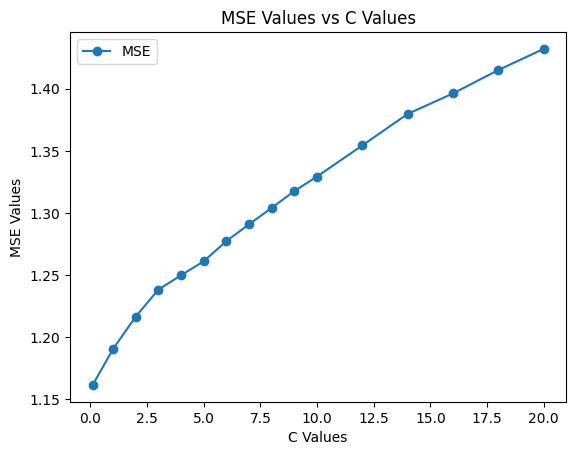

In [ ]:
# Plotting MSE for SVR a RBF Kernel: Epsilon = 0.01, C Changes
plt.plot(C_values, mse_svr_C_values, label='MSE', marker='o')
plt.xlabel('C Values')
plt.ylabel('MSE Values')
plt.title('MSE Values vs C Values')
plt.legend()
plt.show()

In [ ]:
#Lower values of C gives the best MSE

epsilon_values = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10]
C = 0.1
mse_svr_epsilon_values = []


for i in epsilon_values:
    svr_predictions_E = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), 'rbf', C, i)

    mse_svr_E, r_mse_svr_E, mae_svr_E = compute_metrics(y_val, svr_predictions_E)

    mse_svr_epsilon_values.append(mse_svr_E)

    print("Mean Squared Error for Epsilon =", i, ":", mse_svr_E)
    # print("Root Mean Squared Error for C =", i, ":", r_mse_svr_C)
    # print("Mean Absolute Error forC =", i, ":", mae_svr_C)
    print("")

Mean Squared Error for Epsilon = 0.001 : 1.1606602699480046

Mean Squared Error for Epsilon = 0.01 : 1.1615470888787183

Mean Squared Error for Epsilon = 0.1 : 1.148526522445705

Mean Squared Error for Epsilon = 0.2 : 1.1356978271207896

Mean Squared Error for Epsilon = 0.5 : 1.1251970441880508

Mean Squared Error for Epsilon = 1 : 1.0993229862277971

Mean Squared Error for Epsilon = 2 : 1.3193462373362788

Mean Squared Error for Epsilon = 5 : 4.568633285215847

Mean Squared Error for Epsilon = 10 : 4.568633285215847



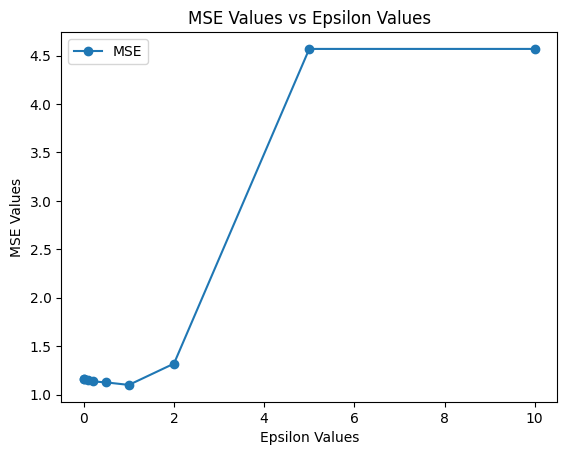

In [ ]:
# Plotting MSE for SVR a RBF Kernel: C = 0.1, Epsilon Changes
plt.plot(epsilon_values, mse_svr_epsilon_values, label='MSE', marker='o')
plt.xlabel('Epsilon Values')
plt.ylabel('MSE Values')
plt.title('MSE Values vs Epsilon Values')
plt.legend()
plt.show()

#### Out-of-Class Models

##### Random Forest

In [ ]:
#RH

def random_forest(num_trees, train_data, train_label, val_data, val_label):
    random_forest_model = RandomForestRegressor(n_estimators = num_trees, random_state = 42)
    random_forest_model.fit(train_data, train_label)
    predictions = random_forest_model.predict(val_data)

    return predictions


In [ ]:
num_tree_values = [10, 50, 100, 250]

for i in num_tree_values:
    rf_predictions = random_forest(i, x_train, y_train.ravel(), x_val, y_val.ravel())
    mse_rf, r_mse_rf, mae_rf = compute_metrics(y_val, rf_predictions)


    print(f"Number of Random Forests: {i} \n")
    print("Mean Squared Error: ", mse_rf)
    print("Root Mean Squared Error: ", r_mse_rf)
    print("Mean Absolute Error :", mae_rf)
    print("")

Number of Random Forests: 10 

Mean Squared Error:  1.2815431614652415
Root Mean Squared Error:  1.132052631932474
Mean Absolute Error : 0.777593907527566

Number of Random Forests: 50 

Mean Squared Error:  1.1811849228725204
Root Mean Squared Error:  1.0868233172289414
Mean Absolute Error : 0.7225597438263576

Number of Random Forests: 100 

Mean Squared Error:  1.1730482858675517
Root Mean Squared Error:  1.0830735366850912
Mean Absolute Error : 0.724760821708454

Number of Random Forests: 250 

Mean Squared Error:  1.192518493872718
Root Mean Squared Error:  1.0920249511218678
Mean Absolute Error : 0.727308298732651



##### Gradient Boosting

In [ ]:
#HC

##### Long Short Term Memory Neural Network (LSTM)

In [ ]:
#HC

### Results

### Final Predictions on Test Set

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=498fdfc4-75bb-4c68-a720-cea81bc987b7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>